In [2]:
import argparse
import math
import gradio
import os
import torch
import numpy as np
import tempfile
import functools
import trimesh
import copy
from scipy.spatial.transform import Rotation

from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.image_pairs import make_pairs
from dust3r.utils.image import load_images, rgb
from dust3r.utils.device import to_numpy
from dust3r.viz import add_scene_cam, CAM_COLORS, OPENGL, pts3d_to_trimesh, cat_meshes
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

/home/razi/anaconda3/envs/dust3r/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


In [3]:

def _convert_scene_output_to_glb(outdir, imgs, pts3d, mask, focals, cams2world, cam_size=0.05,
                                 cam_color=None, as_pointcloud=False,
                                 transparent_cams=False, silent=False):
    assert len(pts3d) == len(mask) <= len(imgs) <= len(cams2world) == len(focals)
    pts3d = to_numpy(pts3d)
    imgs = to_numpy(imgs)
    focals = to_numpy(focals)
    cams2world = to_numpy(cams2world)

    scene = trimesh.Scene()

    # full pointcloud
    if as_pointcloud:
        pts = np.concatenate([p[m] for p, m in zip(pts3d, mask)])
        col = np.concatenate([p[m] for p, m in zip(imgs, mask)])
        pct = trimesh.PointCloud(pts.reshape(-1, 3), colors=col.reshape(-1, 3))
        scene.add_geometry(pct)
    else:
        meshes = []
        for i in range(len(imgs)):
            meshes.append(pts3d_to_trimesh(imgs[i], pts3d[i], mask[i]))
        mesh = trimesh.Trimesh(**cat_meshes(meshes))
        scene.add_geometry(mesh)

    # add each camera
    for i, pose_c2w in enumerate(cams2world):
        if isinstance(cam_color, list):
            camera_edge_color = cam_color[i]
        else:
            camera_edge_color = cam_color or CAM_COLORS[i % len(CAM_COLORS)]
        add_scene_cam(scene, pose_c2w, camera_edge_color,
                      None if transparent_cams else imgs[i], focals[i],
                      imsize=imgs[i].shape[1::-1], screen_width=cam_size)

    rot = np.eye(4)
    rot[:3, :3] = Rotation.from_euler('y', np.deg2rad(180)).as_matrix()
    scene.apply_transform(np.linalg.inv(cams2world[0] @ OPENGL @ rot))
    outfile = outdir #os.path.join(outdir, 'scene.glb')
    if not silent:
        print('(exporting 3D scene to', outfile, ')')
    scene.export(file_obj=outfile)
    return outfile

def get_3D_model_from_scene(outdir, silent, scene, min_conf_thr=3, as_pointcloud=False, mask_sky=False,
                            clean_depth=False, transparent_cams=False, cam_size=0.05):
    """
    extract 3D_model (glb file) from a reconstructed scene
    """
    if scene is None:
        return None
    # post processes
    if clean_depth:
        scene = scene.clean_pointcloud()
    if mask_sky:
        scene = scene.mask_sky()

    # get optimized values from scene
    rgbimg = scene.imgs
    focals = scene.get_focals().cpu()
    cams2world = scene.get_im_poses().cpu()
    # 3D pointcloud from depthmap, poses and intrinsics
    pts3d = to_numpy(scene.get_pts3d())
    scene.min_conf_thr = float(scene.conf_trf(torch.tensor(min_conf_thr)))
    msk = to_numpy(scene.get_masks())
    return _convert_scene_output_to_glb(outdir, rgbimg, pts3d, msk, focals, cams2world, as_pointcloud=as_pointcloud,
                                        transparent_cams=transparent_cams, cam_size=cam_size, silent=silent)

In [4]:
from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

def getPointcloudFromImagesWithDust3r(input_images = ['cup1.jpg', 'cup2.jpg', 'cup3.jpg']):
    device = 'cuda'
    batch_size = 1
    schedule = 'cosine'
    lr = 0.01
    niter = 300

    model_name = "naver/DUSt3R_ViTLarge_BaseDecoder_512_dpt"
    # you can put the path to a local checkpoint in model_name if needed
    model = AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device)
    # load_images can take a list of images or a directory
    # images = load_images(['croco/assets/Chateau1.png', 'croco/assets/Chateau2.png'], size=512)
    images = load_images(input_images, size=512)
    pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
    output = inference(pairs, model, device, batch_size=batch_size)

    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    view2, pred2 = output['view2'], output['pred2']
    # here, view1, pred1, view2, pred2 are dicts of lists of len(2)
    #  -> because we symmetrize we have (im1, im2) and (im2, im1) pairs
    # in each view you have:
    # an integer image identifier: view1['idx'] and view2['idx']
    # the img: view1['img'] and view2['img']
    # the image shape: view1['true_shape'] and view2['true_shape']
    # an instance string output by the dataloader: view1['instance'] and view2['instance']
    # pred1 and pred2 contains the confidence values: pred1['conf'] and pred2['conf']
    # pred1 contains 3D points for view1['img'] in view1['img'] space: pred1['pts3d']
    # pred2 contains 3D points for view2['img'] in view1['img'] space: pred2['pts3d_in_other_view']

    # next we'll use the global_aligner to align the predictions
    # depending on your task, you may be fine with the raw output and not need it
    # with only two input images, you could use GlobalAlignerMode.PairViewer: it would just convert the output
    # if using GlobalAlignerMode.PairViewer, no need to run compute_global_alignment
    scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
    loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

    # retrieve useful values from scene:
    imgs = scene.imgs
    focals = scene.get_focals()
    poses = scene.get_im_poses()
    pts3d = scene.get_pts3d()
    confidence_masks = scene.get_masks()

    # visualize reconstruction
    scene.show()

    get_3D_model_from_scene('output.glb', silent=False, scene=scene, min_conf_thr=3, as_pointcloud=True, mask_sky=True,)
    

    # find 2D-2D matches between the two images
    from dust3r.utils.geometry import find_reciprocal_matches, xy_grid
    pts2d_list, pts3d_list = [], []
    for i in range(2):
        conf_i = confidence_masks[i].cpu().numpy()
        pts2d_list.append(xy_grid(*imgs[i].shape[:2][::-1])[conf_i])  # imgs[i].shape[:2] = (H, W)
        pts3d_list.append(pts3d[i].detach().cpu().numpy()[conf_i])
    reciprocal_in_P2, nn2_in_P1, num_matches = find_reciprocal_matches(*pts3d_list)
    print(f'found {num_matches} matches')
    matches_im1 = pts2d_list[1][reciprocal_in_P2]
    matches_im0 = pts2d_list[0][nn2_in_P1][reciprocal_in_P2]

    # visualize a few matches
    import numpy as np
    from matplotlib import pyplot as pl
    n_viz = 10
    match_idx_to_viz = np.round(np.linspace(0, num_matches-1, n_viz)).astype(int)
    viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

    H0, W0, H1, W1 = *imgs[0].shape[:2], *imgs[1].shape[:2]
    img0 = np.pad(imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
    img1 = np.pad(imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
    img = np.concatenate((img0, img1), axis=1)
    pl.figure()
    pl.imshow(img)
    cmap = pl.get_cmap('jet')
    for i in range(n_viz):
        (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
        pl.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
    pl.show(block=True)


>> Loading a list of 3 images
 - adding cup1.jpg with resolution 1500x2000 --> 384x512
 - adding cup2.jpg with resolution 1500x2000 --> 384x512
 - adding cup3.jpg with resolution 1500x2000 --> 384x512
 (Found 3 images)
>> Inference with model on 6 image pairs


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


 init edge (1*,0*) score=10.008795738220215
 init edge (1,2*) score=8.83539867401123
 init loss = 0.0035070006269961596
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals', 'im_conf.0', 'im_conf.1', 'im_conf.2']


100%|██████████| 300/300 [00:26<00:00, 11.13it/s, lr=0.01 loss=0.00256689]


(exporting 3D scene to output.glb )
found 12586 matches


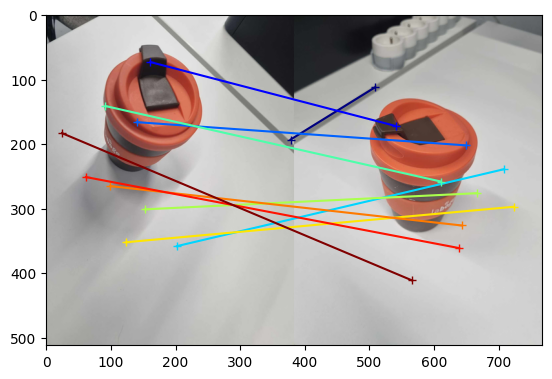

In [5]:
getPointcloudFromImagesWithDust3r(input_images = ['cup1.jpg', 'cup2.jpg', 'cup3.jpg'])

In [11]:
from flask import Flask, request, render_template, jsonify, send_file
from flask_cors import CORS

changed = False

app = Flask(__name__)
CORS(app)

@app.route('/')
def index():
    return jsonify({'message': 'Hello, World!'})
    # return render_template('upload.html')

@app.route('/upload', methods=['POST',])
def upload_image():
  # Get the uploaded image file
  print("in post")
  try:
    image_file = request.files['imageFile']
  except Exception as e:
    return jsonify({'error': 'No image file uploaded'}), 400

  # Check if a file is uploaded
  if image_file.filename == '':
    return jsonify({'error': 'No selected file'}), 400

  # Save the image (optional)
  # You can save the image to a specific location on your server
  print(f'Saving image to uploads/{image_file.filename}')
  image_file.save(f'uploads/{image_file.filename}')

  try:
    image_file2 = request.files['imageFile2']
  except Exception as e:
    return jsonify({'error': 'No image2 file uploaded'}), 400

  # Check if a file is uploaded
  if image_file2.filename == '':
    return jsonify({'error': 'No selected file'}), 400

  # Save the image (optional)
  # You can save the image to a specific location on your server
  print(f'Saving image to uploads/{image_file2.filename}')
  image_file2.save(f'uploads/{image_file2.filename}')


  # Process the image (optional)
  getPointcloudFromImagesWithDust3r(input_images = [f'uploads/{image_file.filename}', f'uploads/{image_file2.filename}'])
  
  global changed
  changed = True
  
  # You can use libraries like Pillow (PIL Fork) to process the image
  # Do something with the image data (e.g., resize, convert format)

  # Return a success message
  return jsonify({'message': 'Image uploaded successfully!'}), 200

@app.route('/hello', methods=['GET'])
def hello():
    return jsonify({'message': 'Hello, World!'})

@app.route('/change', methods=['GET'])
def change():
    if changed:
      return jsonify(True)
    else:
      return jsonify(False)
    
@app.route('/uploadFront', methods=['GET'])
def uploadFrontEnd():
    return render_template('upload.html')

@app.route('/MR', methods=['GET'])
def MRFrontEnd():
    return render_template('index.html')

@app.route('/output', methods=['GET'])
def get_output():
    global changed
    changed = False
    
    if (os.path.exists('output.glb')):
      return send_file('output.glb', as_attachment=True)
    else:
      return jsonify({'error': 'No output file found'}), 400
    

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5001, ssl_context='adhoc')

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on https://127.0.0.1:5001
 * Running on https://172.19.99.252:5001
Press CTRL+C to quit
172.19.96.1 - - [03/May/2024 09:49:21] "GET /MR HTTP/1.1" 200 -


In [ ]:
# !pip install flask_cors


In [ ]:
# !pip install pyopenssl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.8/464.8 kB 1.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 kB 1.5 MB/s eta 0:00:00a 0:00:01
